In [2]:
! pip install gensim

     |████████████████████████████████| 24.7MB 12.5MB/s eta 0:00:01
     |████████████████████████████████| 71kB 12.7MB/s eta 0:00:01
     |████████████████████████████████| 133kB 29.7MB/s eta 0:00:01
     |████████████████████████████████| 71kB 17.6MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 25.9MB/s eta 0:00:01
  Stored in directory: /Users/xialu/Library/Caches/pip/wheels/ab/10/93/5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open


In [122]:
import pandas as pd 
import numpy as np
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
import re
import collections
import operator
import os
import pickle
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import doc2vec
from collections import namedtuple
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [199]:
import matplotlib.pyplot as plt

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/xialu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 1.Data-preprocesssing, exclude special character / space / number 

In [2]:
# Pre-process file, set exclude_digit = True if do not include digit 
def pre_process(file_content, exclude_digit = False):
    
    processed_article = file_content.lower()
    
    # Decide whether to exclude the digit or not 
    if exclude_digit is False:
    
        # Include digit
        processed_article = re.sub(',', '', processed_article )
        processed_article = re.sub('[^a-zA-Z0-9]', ' ', processed_article )
    else: 
        # Exclude digit
        processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )

    processed_article = re.sub(r'\s+', ' ', processed_article)
    
    
    return processed_article

# 2. Using stop words list to reduce content and Exclude word length < 4

In [3]:
def Exclude_by_Stop_words (processed_article, stop_words_list):
    all_sentences = nltk.sent_tokenize(processed_article)
    
    if len(all_sentences) == 1:
        all_words = nltk.word_tokenize(all_sentences[0])
#         print('There are',len(all_words),'words.')
        
        all_words = [word for word in all_words if len(word) >4 ]
#         print('There are',len(all_words),'has more than 4 characters.')

        all_words = [word for word in all_words if word not in stop_words_list]
#         print('There are',len(all_words),'after removed stop_words.\n')
        
        return all_words
    
    else:
        print('Length > 1.')

# 3. Using IQR to remove outliers from our target y (adjust_stock prices)

In [ ]:
# dataframe = data include 10k_file_name and adjusted stock prices
# column_name = adjusted stock prices
# outlierConstant = default is 5, you can change it if you want

def remove_Outliers(dataframe, column_name, outlierConstant = 1.5):
    a = np.array(dataframe[column_name])
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    index_list = []
    for i in range(0,len(a)):
        value = a[i]s
        if value <= quartileSet[0] or value >= quartileSet[1]:
            index_list.append(i)
            
    new_dataframe = dataframe[~dataframe.index.isin(index_list)].reset_index(drop = True)
    
    print('upper_quartile is',round(upper_quartile,3))
    print('lower_quartile is',round(lower_quartile,3))
    print('IQR is',round(IQR,3))
    print('quartileSet is',quartileSet)
    print('dataset size:', len(a))
    print('Number of outliers:',len(index_list),'\n')

    return new_dataframe

# 4. Using Exclude_Stop_words function to create a list of content for all 10K files in the file

In [104]:
# Remove words by new stop_words_list

# folder_path = folder that contain the 10k files
# file_name_list = list of 10k files that have adjusted stock prices

def list_content_for_model(folder_path = None,file_name_list = None):
#     file_name_1996 = os.listdir('/Users/jinbinliang/Desktop/ISE599/Project/10K/2004.full')
    stop_words_list = []
    list_10k_contents = []
    
    # replace file_path to your stop words location
    with open("stop_word.txt", "r") as f:
        for line in f:
            stop_words_list.append(str(line.strip()))

    Num_doc = len(file_name_list)
    count = 1
    for file_name in file_name_list:
#         file_name = file_name_1996[i]
        file_path = folder_path + file_name
        f = open(file_path,'r')
        pre_processed_article = f.read()[3000:]
        f.close()
        processed_article = pre_process(pre_processed_article)
        Exclude_word_processed_article = Exclude_by_Stop_words(processed_article,stop_words_list)
        list_10k_contents.append(Exclude_word_processed_article)
        #print(count,'/',Num_doc,'completed')
        count += 1
    print(Num_doc, 'completed')
    return list_10k_contents

# 5. Build a doc_model to compute all of 10K files' vector.

In [31]:
# list_10k_contents = 10k file contents
# vector_size = number of vector for each docs

def doc_model(list_10k_contents, vector_size = 30, window = 30, min_count = 2):
    docs = []
    analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
    for i, text in enumerate(list_10k_contents):
        tags = [i]
        docs.append(analyzedDocument(text, tags))
    v
    model = doc2vec.Doc2Vec(docs, vector_size = vector_size, window = window, min_count = min_count, workers = 4)
    #print('There are',len(list(model.docvecs)))
    return model 

In [33]:
def construct_X(doc_vectors):
    x = []
    
    for vector in range(0,len(doc_vectors.docvecs)):
        x.append(list(doc_vectors[vector]))
    
    return x

# 6. Build regression model

In [1]:
# Separate train and test set 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [131]:
def model(X,y, model_name = 'linear'):
    
    if model_name == 'linear':
        model = LinearRegression().fit(X, y)
    if model_name == 'ridge':
        model = linear_model.Ridge(alpha=0.5).fit(X, y)
    if model_name == 'lasso':
        model = linear_model.Lasso(alpha=0.1).fit(X, y)
    if model_name == 'tree':
        model = DecisionTreeRegressor(random_state=0)
    if model_name == 'forest':
        model = RandomForestRegressor(n_estimators = 100, random_state = 1)
        
    return model

In [38]:
def evaluation_model(model, x_train, y_train, x_test, y_test):
    
    eva_result = []
    cv_mse = cross_val_score(model,x_train, y_train, cv=10, scoring='neg_mean_squared_error' )
    eva_result.append(cv_mse.mean())
    cv_mbe = cross_val_score(model,x_train, y_train, cv=10, scoring='neg_mean_absolute_error' )
    eva_result.append(cv_mbe.mean())
    cv_r2 = cross_val_score(model,x_train, y_train, cv=10, scoring='r2' )
    eva_result.append(cv_r2.mean())
    print('CV mse is',round(np.mean(cv_mse),4))
    print('CV mbe is',round(np.mean(cv_mbe),4))
    print('CV R^2 is',round(np.mean(cv_r2),4),'\n')
    
    y_pred = model.predict(x_test)
    test_mse = mean_squared_error(y_test, y_pred)
    print('Test mse is',round(test_mse,4))
    eva_result.append(test_mse)
    return eva_result

In [ ]:
linear_model.Ridge()

# Document Embedding Parameter Tuning
## -- vector_size, window, min_count

In [ ]:
file_list = pd.read_csv('CIK_Symbol_map/2002_10k_2003_price.csv').filename.values()
file_list

In [ ]:
y2002 = list_content_for_model(folder_path = '/2002/',file_name_list = None)

### remove_Outliers -- outlierConstant = 5

In [14]:
d1 = pd.read_csv('CIK_Symbol_map/2002_10k_2003_price.csv')
d2 = remove_Outliers(d1, 'close_adjusted', outlierConstant = 5)
file_10k_name = d2['filename']

upper_quartile is 17.354
lower_quartile is 5.096
IQR is 61.288
quartileSet is (-56.19213293650787, 78.64181190476182)
dataset size: 857
Number of outliers: 28 



In [82]:
d1 = pd.read_csv('CIK_Symbol_map/2002_10k_2003_price.csv')
d2 = remove_Outliers(d1, 'close_adjusted', outlierConstant = 1.5)
second_file_10k_name = d2['filename']

upper_quartile is 17.354
lower_quartile is 5.096
IQR is 18.386
quartileSet is (-13.290423214285692, 35.740102182539644)
dataset size: 857
Number of outliers: 58 



In [22]:
folder_10k = '2002.full/'
list_10k_contents = list_content_for_model(folder_10k,file_10k_name)

1 / 829 completed
2 / 829 completed
3 / 829 completed
4 / 829 completed
5 / 829 completed
6 / 829 completed
7 / 829 completed
8 / 829 completed
9 / 829 completed
10 / 829 completed
11 / 829 completed
12 / 829 completed
13 / 829 completed
14 / 829 completed
15 / 829 completed
16 / 829 completed
17 / 829 completed
18 / 829 completed
19 / 829 completed
20 / 829 completed
21 / 829 completed
22 / 829 completed
23 / 829 completed
24 / 829 completed
25 / 829 completed
26 / 829 completed
27 / 829 completed
28 / 829 completed
29 / 829 completed
30 / 829 completed
31 / 829 completed
32 / 829 completed
33 / 829 completed
34 / 829 completed
35 / 829 completed
36 / 829 completed
37 / 829 completed
38 / 829 completed
39 / 829 completed
40 / 829 completed
41 / 829 completed
42 / 829 completed
43 / 829 completed
44 / 829 completed
45 / 829 completed
46 / 829 completed
47 / 829 completed
48 / 829 completed
49 / 829 completed
50 / 829 completed
51 / 829 completed
52 / 829 completed
53 / 829 completed
54

417 / 829 completed
418 / 829 completed
419 / 829 completed
420 / 829 completed
421 / 829 completed
422 / 829 completed
423 / 829 completed
424 / 829 completed
425 / 829 completed
426 / 829 completed
427 / 829 completed
428 / 829 completed
429 / 829 completed
430 / 829 completed
431 / 829 completed
432 / 829 completed
433 / 829 completed
434 / 829 completed
435 / 829 completed
436 / 829 completed
437 / 829 completed
438 / 829 completed
439 / 829 completed
440 / 829 completed
441 / 829 completed
442 / 829 completed
443 / 829 completed
444 / 829 completed
445 / 829 completed
446 / 829 completed
447 / 829 completed
448 / 829 completed
449 / 829 completed
450 / 829 completed
451 / 829 completed
452 / 829 completed
453 / 829 completed
454 / 829 completed
455 / 829 completed
456 / 829 completed
457 / 829 completed
458 / 829 completed
459 / 829 completed
460 / 829 completed
461 / 829 completed
462 / 829 completed
463 / 829 completed
464 / 829 completed
465 / 829 completed
466 / 829 completed


828 / 829 completed
829 / 829 completed


In [40]:
result = []

for i in range(10, 80, 20):
    doc_vector_model = doc_model(list_10k_contents, vector_size = i, window = 300, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    result.append(evaluation_model(reg_model, X_train, y_train, X_test, y_test))

CV mse is -110.501
CV mbe is -7.5643
CV R^2 is -0.0699 

Test mse is 137.3322
CV mse is -111.1645
CV mbe is -7.6531
CV R^2 is -0.0841 

Test mse is 147.0184
CV mse is -116.6285
CV mbe is -7.9211
CV R^2 is -0.1371 

Test mse is 143.385
CV mse is -124.1385
CV mbe is -8.1307
CV R^2 is -0.2003 

Test mse is 147.4374


In [41]:
result

[[-110.50096743430723,
  -7.56426507919997,
  -0.06989014547695156,
  137.3322064455901],
 [-111.16451587496549,
  -7.653136393158311,
  -0.08413810693615509,
  147.01838677162834],
 [-116.62851496800079,
  -7.921087109916023,
  -0.13712671187410175,
  143.38500294985707],
 [-124.13851134767746,
  -8.130735284010532,
  -0.2002625808442357,
  147.43735451977497]]

In [42]:
result2 = []

for i in range(90, 160, 20):
    doc_vector_model = doc_model(list_10k_contents, vector_size = i, window = 300, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    result2.append(evaluation_model(reg_model, X_train, y_train, X_test, y_test))

CV mse is -135.1448
CV mbe is -8.5457
CV R^2 is -0.3037 

Test mse is 152.2323
CV mse is -134.0017
CV mbe is -8.5398
CV R^2 is -0.3008 

Test mse is 168.6928
CV mse is -144.3008
CV mbe is -8.897
CV R^2 is -0.3908 

Test mse is 162.323
CV mse is -155.3205
CV mbe is -9.2466
CV R^2 is -0.5454 

Test mse is 172.2867


In [44]:
result3 = []

for i in range(10, 80, 20):
    doc_vector_model = doc_model(list_10k_contents, vector_size = i, window = 300, min_count = 5)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    result3.append(evaluation_model(reg_model, X_train, y_train, X_test, y_test))

CV mse is -111.1006
CV mbe is -7.6037
CV R^2 is -0.0721 

Test mse is 136.4301
CV mse is -114.2258
CV mbe is -7.7283
CV R^2 is -0.1123 

Test mse is 140.5511
CV mse is -118.3033
CV mbe is -7.9945
CV R^2 is -0.1763 

Test mse is 143.3289
CV mse is -123.8304
CV mbe is -8.1888
CV R^2 is -0.2253 

Test mse is 147.0526


In [45]:
result3

[[-111.10060399325766,
  -7.603695230150704,
  -0.07211066418602188,
  136.43011993475093],
 [-114.22580949370146,
  -7.728270810679892,
  -0.11234905741338186,
  140.55105113499548],
 [-118.30329375377346,
  -7.994541911055012,
  -0.1763072296777763,
  143.3289132831573],
 [-123.83043759139261,
  -8.188821991897113,
  -0.22528123399091865,
  147.05264514067102]]

In [55]:
df = pd.DataFrame(result)
df.columns = ['CV mse', 'CV mbe', 'CV R^2', 'test MSE']

In [56]:
df

,CV mse,CV mbe,CV R^2,test MSE
0,-110.500967,-7.564265,-0.069890,137.332206
1,-111.164516,-7.653136,-0.084138,147.018387
2,-116.628515,-7.921087,-0.137127,143.385003
3,-124.138511,-8.130735,-0.200263,147.437355


In [57]:
df2 = pd.DataFrame(result3)
df2.columns = ['CV mse', 'CV mbe', 'CV R^2', 'test MSE']
df2

,CV mse,CV mbe,CV R^2,test MSE
0,-111.100604,-7.603695,-0.072111,136.430120
1,-114.225809,-7.728271,-0.112349,140.551051
2,-118.303294,-7.994542,-0.176307,143.328913
3,-123.830438,-8.188822,-0.225281,147.052645


In [62]:
array = np.array(result)
array

array([[-1.10500967e+02, -7.56426508e+00, -6.98901455e-02,
         1.37332206e+02],
       [-1.11164516e+02, -7.65313639e+00, -8.41381069e-02,
         1.47018387e+02],
       [-1.16628515e+02, -7.92108711e+00, -1.37126712e-01,
         1.43385003e+02],
       [-1.24138511e+02, -8.13073528e+00, -2.00262581e-01,
         1.47437355e+02]])

In [64]:
CV_mse = [array[0][0], array[1][0], array[2][0], array[3][0]]
CV_mse

[-110.50096743430723,
 -111.16451587496549,
 -116.62851496800079,
 -124.13851134767746]

In [65]:
array2 = np.array(result2)
CV_mse2 = [array2[0][0], array2[1][0], array2[2][0], array2[3][0]]
array3 = np.array(result3)
CV_mse3 = [array3[0][0], array3[1][0], array3[2][0], array3[3][0]]

In [68]:
cv_mse_table = pd.DataFrame()
cv_mse_table['min_count=2'] = CV_mse
cv_mse_table['min_count=5'] = CV_mse3
cv_mse_table.index = ['size = 10', 'size = 30', 'size = 50', 'size = 70']
cv_mse_table

,min_count=2,min_count=5
size = 10,-110.500967,-111.100604
size = 30,-111.164516,-114.225809
size = 50,-116.628515,-118.303294
size = 70,-124.138511,-123.830438


In [72]:
count2 = CV_mse+CV_mse2
table2 = pd.DataFrame({'cv_mse': count2})
table2.index = range(10, 160, 20)
table2

,cv_mse
10,-110.500967
30,-111.164516
50,-116.628515
70,-124.138511
90,-135.144782
110,-134.001655
130,-144.300750
150,-155.320464


In [74]:
test_mse = [array[0][3], array[1][3], array[2][3], array[3][3]]
test_mse2 = [array2[0][3], array2[1][3], array2[2][3], array2[3][3]]
testmse = test_mse+test_mse2
table2['test_mse'] = testmse
table2

,cv_mse,test_mse
10,-110.500967,137.332206
30,-111.164516,147.018387
50,-116.628515,143.385003
70,-124.138511,147.437355
90,-135.144782,152.232318
110,-134.001655,168.692821
130,-144.300750,162.322976
150,-155.320464,172.286681


In [80]:
small_window_result = []

for i in range(10, 80, 20):
    doc_vector_model = doc_model(list_10k_contents, vector_size = i, window = 30, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    small_window_result.append(evaluation_model(reg_model, X_train, y_train, X_test, y_test))

CV mse is -109.2462
CV mbe is -7.536
CV R^2 is -0.0513 

Test mse is 133.2588
CV mse is -112.0172
CV mbe is -7.7053
CV R^2 is -0.0902 

Test mse is 139.6493
CV mse is -110.3651
CV mbe is -7.6104
CV R^2 is -0.0647 

Test mse is 145.5689
CV mse is -117.7098
CV mbe is -8.0409
CV R^2 is -0.1425 

Test mse is 153.6997


### remove_Outliers -- outlierConstant = 1.5

In [ ]:
d1 = pd.read_csv('CIK_Symbol_map/2002_10k_2003_price.csv')
d2 = remove_Outliers(d1, 'close_adjusted', outlierConstant = 1.5)
second_file_10k_name = d2['filename']

In [83]:
folder_10k = '2002.full/'
second_list_10k_contents = list_content_for_model(folder_10k, second_file_10k_name)

new_result = []
for i in range(10, 80, 20):
    doc_vector_model = doc_model(second_list_10k_contents, vector_size = i, window = 30, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    new_result.append(evaluation_model(reg_model, X_train, y_train, X_test, y_test))

1 / 799 completed
2 / 799 completed
3 / 799 completed
4 / 799 completed
5 / 799 completed
6 / 799 completed
7 / 799 completed
8 / 799 completed
9 / 799 completed
10 / 799 completed
11 / 799 completed
12 / 799 completed
13 / 799 completed
14 / 799 completed
15 / 799 completed
16 / 799 completed
17 / 799 completed
18 / 799 completed
19 / 799 completed
20 / 799 completed
21 / 799 completed
22 / 799 completed
23 / 799 completed
24 / 799 completed
25 / 799 completed
26 / 799 completed
27 / 799 completed
28 / 799 completed
29 / 799 completed
30 / 799 completed
31 / 799 completed
32 / 799 completed
33 / 799 completed
34 / 799 completed
35 / 799 completed
36 / 799 completed
37 / 799 completed
38 / 799 completed
39 / 799 completed
40 / 799 completed
41 / 799 completed
42 / 799 completed
43 / 799 completed
44 / 799 completed
45 / 799 completed
46 / 799 completed
47 / 799 completed
48 / 799 completed
49 / 799 completed
50 / 799 completed
51 / 799 completed
52 / 799 completed
53 / 799 completed
54

417 / 799 completed
418 / 799 completed
419 / 799 completed
420 / 799 completed
421 / 799 completed
422 / 799 completed
423 / 799 completed
424 / 799 completed
425 / 799 completed
426 / 799 completed
427 / 799 completed
428 / 799 completed
429 / 799 completed
430 / 799 completed
431 / 799 completed
432 / 799 completed
433 / 799 completed
434 / 799 completed
435 / 799 completed
436 / 799 completed
437 / 799 completed
438 / 799 completed
439 / 799 completed
440 / 799 completed
441 / 799 completed
442 / 799 completed
443 / 799 completed
444 / 799 completed
445 / 799 completed
446 / 799 completed
447 / 799 completed
448 / 799 completed
449 / 799 completed
450 / 799 completed
451 / 799 completed
452 / 799 completed
453 / 799 completed
454 / 799 completed
455 / 799 completed
456 / 799 completed
457 / 799 completed
458 / 799 completed
459 / 799 completed
460 / 799 completed
461 / 799 completed
462 / 799 completed
463 / 799 completed
464 / 799 completed
465 / 799 completed
466 / 799 completed


In [84]:
new_result

[[-59.8058922288845,
  -6.168051307086854,
  -0.033940096753366455,
  60.74884084854393],
 [-62.15739349510325,
  -6.245841079233602,
  -0.09099404654518058,
  62.506340790102236],
 [-62.61875401461591,
  -6.24119630991542,
  -0.08183961753457653,
  61.037909422969115],
 [-65.1636812952963,
  -6.308261917690073,
  -0.1343498485412242,
  59.97816880591405]]

In [85]:
new_result2 = []
for i in range(10, 80, 20):
    doc_vector_model = doc_model(second_list_10k_contents, vector_size = i, window = 30, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    new_result2.append(evaluation_model(reg_model, X_train, y_train, X_validation, y_validation))

CV mse is -61.1734
CV mbe is -6.2163
CV R^2 is -0.0425 

Test mse is 61.2371
CV mse is -63.2565
CV mbe is -6.2163
CV R^2 is -0.0959 

Test mse is 67.9622
CV mse is -64.7304
CV mbe is -6.3091
CV R^2 is -0.1228 

Test mse is 66.3529
CV mse is -65.8788
CV mbe is -6.2768
CV R^2 is -0.1446 

Test mse is 72.2441


In [86]:
# size = 10 is the best 

In [103]:
new_result2 = np.array(new_result2)
new_of = pd.DataFrame(columns = ['MSE', 'MBE', 'R^2'], index = range(10,80,20))
row = 0
for value in new_result2:
    new_of.iloc[row,0] = value[0]
    new_of.iloc[row,1] = value[1]
    new_of.iloc[row,2] = value[2]
    row +=1 
#new_of.to_csv('docu_embedding_param_result.csv')

In [90]:
a = new_result2[0]

In [101]:
new_of

,MSE,MBE,R^2
10,-61.1734,-6.21625,-0.0424786
30,-63.2565,-6.21635,-0.0959021
50,-64.7304,-6.30906,-0.122781
70,-65.8788,-6.27684,-0.144644


In [2]:
# the best parameter is :  outlierConstant = 1.5 & vector_size = 10, window = 30, min_count = 2

# Baseline Model -- Document Embedding

In [112]:
file_10k_name_list = os.listdir('CIK_Symbol_map/')
file_10k_name_list.sort()
file_10k_name_list

['1997_10k_1998_price.csv',
 '1998_10k_1999_price.csv',
 '1999_10k_2000_price.csv',
 '2000_10k_2001_price.csv',
 '2001_10k_2002_price.csv',
 '2002_10k_2003_price.csv',
 '2003_10k_2004_price.csv',
 '2004_10k_2005_price.csv',
 '2005_10k_2006_price.csv']

In [114]:
folder_10K_list = ['1997.full/', '1998.full/', '1999.full/', '2000.full/', '2001.full/', '2002.full/', '2003.full/', '2004.full/', '2005.full/']
all_result = []

for i in range(9):
    
    d1 = pd.read_csv('CIK_Symbol_map/'+ file_10k_name_list[i])
    d2 = remove_Outliers(d1, 'close_adjusted')
    file_10k_name = d2['filename']
    folder_10k = folder_10K_list[i]
    list_10k_contents = list_content_for_model(folder_10k, file_10k_name)

    doc_vector_model = doc_model(list_10k_contents, vector_size = 10, window = 30, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    eva_result = evaluation_model(reg_model, X_train, y_train, X_test, y_test)
    all_result.append(eva_result[3])
    
print('test MSE of all year:', all_result)

upper_quartile is 14.135
lower_quartile is 4.248
IQR is 14.831
quartileSet is (-10.583215029761899, 28.966451240079365)
dataset size: 398
Number of outliers: 43 

355 completed
CV mse is -43.9167
CV mbe is -5.2601
CV R^2 is -0.0546 

Test mse is 31.8068
upper_quartile is 14.893
lower_quartile is 3.921
IQR is 16.457
quartileSet is (-12.536613740079382, 31.350017609127015)
dataset size: 468
Number of outliers: 40 

428 completed
CV mse is -45.9081
CV mbe is -5.3136
CV R^2 is -0.0747 

Test mse is 48.3396
upper_quartile is 19.263
lower_quartile is 4.065
IQR is 22.797
quartileSet is (-18.732531746031764, 42.05978571428574)
dataset size: 569
Number of outliers: 57 

512 completed
CV mse is -81.1224
CV mbe is -6.8864
CV R^2 is 0.0129 

Test mse is 76.8702
upper_quartile is 18.266
lower_quartile is 4.193
IQR is 21.109
quartileSet is (-16.915363810483882, 39.37425070564518)
dataset size: 610
Number of outliers: 39 

571 completed
CV mse is -74.5255
CV mbe is -6.8288
CV R^2 is 0.0012 

Test mse

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 784645: invalid start byte

In [117]:
for i in range(7, 9):
    
    d1 = pd.read_csv('CIK_Symbol_map/'+ file_10k_name_list[i])
    d2 = remove_Outliers(d1, 'close_adjusted')
    file_10k_name = d2['filename']
    folder_10k = folder_10K_list[i]
    list_10k_contents = list_content_for_model(folder_10k, file_10k_name)

    doc_vector_model = doc_model(list_10k_contents, vector_size = 10, window = 30, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    eva_result = evaluation_model(reg_model, X_train, y_train, X_test, y_test)
    all_result.append(eva_result[3])
    
print('test MSE of all year:', all_result)

upper_quartile is 24.792
lower_quartile is 8.621
IQR is 24.257
quartileSet is (-15.635605158730197, 49.04866785714292)
dataset size: 1304
Number of outliers: 87 

1217 completed
CV mse is -114.529
CV mbe is -8.5012
CV R^2 is -0.0195 

Test mse is 107.5947
upper_quartile is 28.247
lower_quartile is 10.439
IQR is 26.713
quartileSet is (-16.274206375, 54.959804784999996)
dataset size: 1397
Number of outliers: 98 

1299 completed
CV mse is -129.4734
CV mbe is -8.9918
CV R^2 is 0.0166 

Test mse is 140.06
test MSE of all year: [31.806811400854205, 48.33960360954155, 76.87024300072142, 86.42789733932275, 57.23600262855116, 61.10020059750367, 107.59468365775086, 140.05996320459556]


In [118]:
for i in range(6, 7):
    
    d1 = pd.read_csv('CIK_Symbol_map/'+ file_10k_name_list[i])
    d2 = remove_Outliers(d1, 'close_adjusted')
    file_10k_name = d2['filename']
    folder_10k = folder_10K_list[i]
    list_10k_contents = list_content_for_model(folder_10k, file_10k_name)

    doc_vector_model = doc_model(list_10k_contents, vector_size = 10, window = 30, min_count = 2)
    X = construct_X(doc_vector_model)
    y = d2['close_adjusted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg_model = model(X_train,y_train, model_name = 'linear')
    eva_result = evaluation_model(reg_model, X_train, y_train, X_test, y_test)
    
    #all_result.append(eva_result[3])

#print('test MSE of all year:', all_result)
print(eva_result[3])

upper_quartile is 21.901
lower_quartile is 7.353
IQR is 21.823
quartileSet is (-14.470119442499998, 43.72369245749999)
dataset size: 1198
Number of outliers: 84 

1114 completed
CV mse is -84.9144
CV mbe is -7.344
CV R^2 is 0.0227 

Test mse is 86.982
86.9820482016842


In [119]:
all_result.insert(6, 86.9820482016842)

In [120]:
all_result   # test MSE for document embedding basaline model:

[31.806811400854205,
 48.33960360954155,
 76.87024300072142,
 86.42789733932275,
 57.23600262855116,
 61.10020059750367,
 86.9820482016842,
 107.59468365775086,
 140.05996320459556]

# Baseline model -- Price feature

In [230]:
all_feature_10k_name_list = os.listdir('all_features/')
all_feature_10k_name_list.sort()
del all_feature_10k_name_list[0]     

In [231]:
all_feature_10k_name_list

['1998_10k_1999_price_all_features.csv',
 '1999_10k_2000_price_all_features.csv',
 '2000_10k_2001_price_all_features.csv',
 '2001_10k_2002_price_all_features.csv',
 '2002_10k_2003_price_all_features.csv',
 '2003_10k_2004_price_all_features.csv',
 '2004_10k_2005_price_all_features.csv',
 '2005_10k_2006_price_all_features.csv',
 '2006_10k_2007_price_all_features.csv']

In [232]:
base_mse = []
for i in range(9):
    
    d1 = pd.read_csv('all_features/'+ all_feature_10k_name_list[i])
    d2 = remove_Outliers(d1, 'close_adjusted_x')
    d3 = remove_Outliers(d2, 'close_adjusted_y')
    
    X = d3[['high', 'low', 'close_adjusted_x']]
    y = d3['close_adjusted_y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    reg_model = model(X_train,y_train, model_name = 'linear')
    eva_result = evaluation_model(reg_model, X_train, y_train, X_test, y_test)
    base_mse.append(eva_result[3])

upper_quartile is 14.096
lower_quartile is 4.286
IQR is 14.715
quartileSet is (-10.429813548124997, 28.811082896874993)
dataset size: 450
Number of outliers: 34 

upper_quartile is 12.005
lower_quartile is 3.562
IQR is 12.665
quartileSet is (-9.102949748750001, 24.669418893250004)
dataset size: 416
Number of outliers: 16 

CV mse is -7.7543
CV mbe is -1.9627
CV R^2 is 0.7168 

Test mse is 10.7545
upper_quartile is 14.815
lower_quartile is 3.692
IQR is 16.685
quartileSet is (-12.993488095238105, 31.5002150793651)
dataset size: 527
Number of outliers: 33 

upper_quartile is 14.454
lower_quartile is 3.674
IQR is 16.171
quartileSet is (-12.497080505952386, 30.624665128968267)
dataset size: 494
Number of outliers: 36 

CV mse is -22.0415
CV mbe is -3.265
CV R^2 is 0.5243 

Test mse is 13.081
upper_quartile is 17.526
lower_quartile is 4.056
IQR is 20.204
quartileSet is (-16.147954017857145, 37.73030987103175)
dataset size: 588
Number of outliers: 47 

upper_quartile is 14.75
lower_quartile i

In [233]:
base_mse

[10.754513003548727,
 13.081017105530245,
 12.696063747111403,
 11.647713991846366,
 10.440599584073203,
 12.083771325985982,
 14.74509369113435,
 18.801633234486168,
 21.102631490709513]

In [194]:
compare = model_mse[0:8]
compare['base_mse'] = base_mse
compare

/Users/xialu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,linear,ridge,lasso,forest,base_mse
1998,10.713911,10.713828,10.616382,10.116700,10.754513
1999,15.882932,15.882922,15.796360,17.573488,13.081017
2000,12.765893,12.765896,12.753971,12.412314,12.696064
2001,11.797737,11.797758,11.857437,12.299630,11.647714
2002,10.731634,10.731628,10.697832,10.962394,10.440600
2003,12.028757,12.028757,12.015268,12.280372,12.083771
2004,14.050990,14.050962,13.941727,15.355912,14.745094
2005,18.713646,18.713654,18.749477,20.331426,18.801633


In [195]:
d1 = pd.read_csv('all_features/2006_10k_2007_price_all_features.csv')
d2 = remove_Outliers(d1, 'close_adjusted_x')
d3 = remove_Outliers(d2, 'close_adjusted_y')
file_10k_name = d3['filename']
folder_10k = '2006.full/'
list_10k_contents = list_content_for_model(folder_10k, file_10k_name)

doc_vector_model = doc_model(list_10k_contents, vector_size = 10, window = 30, min_count = 2)
X = countruct_X_with_price_features(doc_vector_model, d3)
y = d3['close_adjusted_y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
for m in range(4):
    name = model_list[m]
    reg_model = model(X_train,y_train, name)
    eva_result = evaluation_model(reg_model, X_train, y_train, X_test, y_test)
    model_result.append(eva_result[3])

upper_quartile is 27.58
lower_quartile is 10.103
IQR is 26.217
quartileSet is (-16.11405916334664, 53.79716792828688)
dataset size: 1382
Number of outliers: 74 

upper_quartile is 28.686
lower_quartile is 10.814
IQR is 26.808
quartileSet is (-15.993602191235063, 55.49330298804781)
dataset size: 1308
Number of outliers: 38 

1270 completed
CV mse is -22.812
CV mbe is -3.4385
CV R^2 is 0.8359 

Test mse is 20.5801
CV mse is -22.812
CV mbe is -3.4385
CV R^2 is 0.8359 

Test mse is 20.5801
CV mse is -22.8109
CV mbe is -3.4373
CV R^2 is 0.8359 

Test mse is 20.5947
CV mse is -25.0727
CV mbe is -3.6386
CV R^2 is 0.8203 

Test mse is 22.2798


## MSE plot of baseline models

In [215]:
result_mse = []
for i in range(9):
    result_mse.append(round(all_result[i], 2))

In [216]:
result_mse

[31.81, 48.34, 76.87, 86.43, 57.24, 61.1, 86.98, 107.59, 140.06]

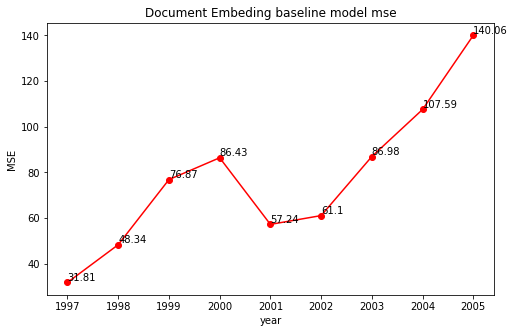

In [237]:
plt.figure(figsize = (8,5))
year_list = range(1997, 2006)
plt.plot(year_list, result_mse, color = 'r', marker = 'o')
for a, b in zip(year_list, result_mse):
    plt.text(a, b, b, va = 'bottom')
plt.title('Document Embeding baseline model mse')
plt.xlabel('year')
plt.ylabel('MSE');

In [238]:
tfidf_mse = [35.12, 41.77, 84.86, 76.56, 50.50, 61.17, 91.48, 125.11, 166.27]

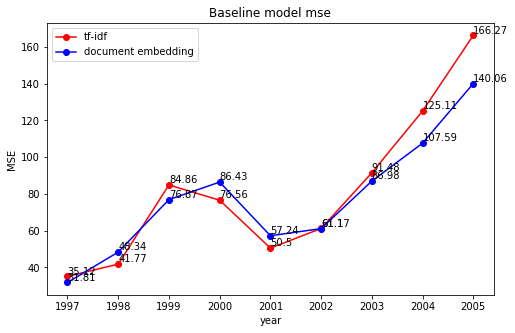

In [242]:
plt.figure(figsize = (8,5))
plt.plot(year_list, tfidf_mse, color = 'r', marker = 'o', label = 'tf-idf')
for a, b in zip(year_list, tfidf_mse):
    plt.text(a, b, b, va = 'bottom')
plt.title('Baseline model mse')
plt.plot(year_list, result_mse, color = 'b', marker = 'o', label = 'document embedding')
for a, b in zip(year_list, result_mse):
    plt.text(a, b, b, va = 'bottom')
plt.legend()
plt.xlabel('year')
plt.ylabel('MSE');

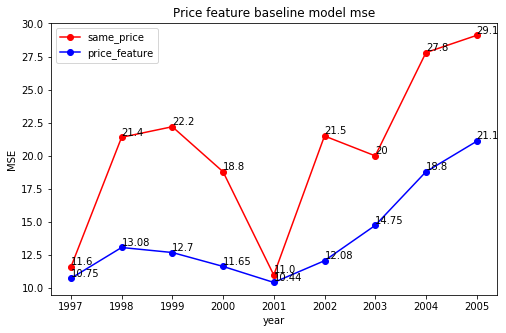

In [246]:
same_price_mse = [11.6, 21.4, 22.2, 18.8, 11.0, 21.5, 20, 27.8, 29.1]
plt.figure(figsize = (8, 5))
plt.plot(year_list, same_price_mse, color = 'r', marker = 'o', label = 'same_price')
for a, b in zip(year_list, same_price_mse):
    plt.text(a, b, b, va = 'bottom')
plt.plot(year_list, price_feature_mse, color = 'b', marker = 'o', label = 'price_feature')
for a, b in zip(year_list, price_feature_mse):
    plt.text(a, b, b, va = 'bottom')
plt.title('Price feature baseline model mse')
plt.legend()
plt.xlabel('year')
plt.ylabel('MSE');

## Build All-feature Predictors
### adding price features on to document embedding

In [121]:
def countruct_X_with_price_features(doc_vectors, dataframe):
    x = []
    for vector in range(0,len(doc_vectors.docvecs)):
        price_features = list(dataframe.loc[vector,['high','low','close_adjusted_x']])

        new_list = list(doc_vectors[vector])+price_features
        x.append(new_list)
        
    return x

In [124]:
d1 = pd.read_csv('all_features/2002_10k_2003_price_all_features.csv')
d2 = remove_Outliers(d1, 'close_adjusted_x')
d3 = remove_Outliers(d2, 'close_adjusted_y')
all_feature_10k_name = d3['filename']
folder_10k = '2002.full/'
list_10k_contents = list_content_for_model(folder_10k, all_feature_10k_name)
doc_vector_model = doc_model(list_10k_contents, vector_size = 10, window = 30, min_count = 2)
X = countruct_X_with_price_features(doc_vector_model, d3)
y = d3['close_adjusted_y']
X_train02, X_test02, y_train02, y_test02 = train_test_split(X, y, test_size=0.33, random_state=42)

upper_quartile is 16.394
lower_quartile is 4.323
IQR is 18.106
quartileSet is (-13.783643154761911, 34.49991160714287)
dataset size: 839
Number of outliers: 56 

upper_quartile is 14.862
lower_quartile is 4.66
IQR is 15.302
quartileSet is (-10.6422873015873, 30.164120634920632)
dataset size: 783
Number of outliers: 18 

765 completed


# Parameter tuning of regression model

In [128]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
ridgecv = linear_model.RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train02, y_train02)
ridgecv.alpha_

0.001

In [130]:
lassocv = linear_model.LassoCV(alphas = alphas, cv = 10, normalize = True, max_iter = 100000)
lassocv.fit(X_train02, y_train02)
lassocv.alpha_

0.01

In [138]:
num_tree = [50, 100, 200, 500]
eva_result = []

for tree in num_tree:
    model = RandomForestRegressor(n_estimators = tree, random_state = 1)
    model.fit(X_train02, y_train02)
    evaluation = evaluation_model(model, X_train02, y_train02, X_test02, y_test02)
    eva_result.append(evaluation[0])
    eva_result.append(evaluation[3])
    
print(eva_result)

CV mse is -10.5426
CV mbe is -2.191
CV R^2 is 0.7493 

Test mse is 11.2254
CV mse is -10.4329
CV mbe is -2.1844
CV R^2 is 0.7529 

Test mse is 11.1656
CV mse is -10.3411
CV mbe is -2.1783
CV R^2 is 0.7543 

Test mse is 11.256
CV mse is -10.3281
CV mbe is -2.1791
CV R^2 is 0.7548 

Test mse is 11.0319
[-10.54256150164014, 11.225367931918498, -10.432945179708588, 11.165585822237885, -10.341079189529841, 11.25600239123361, -10.328073310983015, 11.031862551957685]


In [139]:
eva_result = np.array(eva_result).reshape(-1, 2)
eva_result

array([[-10.5425615 ,  11.22536793],
       [-10.43294518,  11.16558582],
       [-10.34107919,  11.25600239],
       [-10.32807331,  11.03186255]])

In [140]:
# the best n_estimators is 500

### Modify regression model with best parameter

In [169]:
def model(X,y, model_name):
    
    if model_name == 'linear':
        model = LinearRegression().fit(X, y)
    if model_name == 'ridge':
        model = linear_model.Ridge(alpha=0.001).fit(X, y)
    if model_name == 'lasso':
        model = linear_model.Lasso(alpha=0.01, max_iter = 100000).fit(X, y)
    if model_name == 'forest':
        model = RandomForestRegressor(n_estimators = 500, random_state = 1).fit(X, y)
        
    return model

##  Combine 10K (vectorized by document embedding) and price feature to build All-feature Model  &  Make comparison between different regression methods

In [170]:
model_list = ['linear', 'ridge', 'lasso', 'forest']
folder_10K_list = ['1998.full/', '1999.full/', '2000.full/', '2001.full/', '2002.full/', '2003.full/', '2004.full/', '2005.full/']
model_result = []
all_feature_10k_name_list = os.listdir('all_features/')
all_feature_10k_name_list.sort()
del all_feature_10k_name_list[0]     # delete '.DS_Store'

for i in range(8):
    
    d1 = pd.read_csv('all_features/'+ all_feature_10k_name_list[i])
    d2 = remove_Outliers(d1, 'close_adjusted_x')
    d3 = remove_Outliers(d2, 'close_adjusted_y')
    file_10k_name = d3['filename']
    folder_10k = folder_10K_list[i]
    list_10k_contents = list_content_for_model(folder_10k, file_10k_name)

    doc_vector_model = doc_model(list_10k_contents, vector_size = 10, window = 30, min_count = 2)
    X = countruct_X_with_price_features(doc_vector_model, d3)
    y = d3['close_adjusted_y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    for m in range(4):
        name = model_list[m]
        reg_model = model(X_train,y_train, name)
        eva_result = evaluation_model(reg_model, X_train, y_train, X_test, y_test)
        model_result.append(eva_result[3])

print('MSE of each year:', model_result)

upper_quartile is 14.096
lower_quartile is 4.286
IQR is 14.715
quartileSet is (-10.429813548124997, 28.811082896874993)
dataset size: 450
Number of outliers: 34 

upper_quartile is 12.005
lower_quartile is 3.562
IQR is 12.665
quartileSet is (-9.102949748750001, 24.669418893250004)
dataset size: 416
Number of outliers: 16 

400 completed
CV mse is -8.07
CV mbe is -2.0384
CV R^2 is 0.7093 

Test mse is 10.7139
CV mse is -8.07
CV mbe is -2.0384
CV R^2 is 0.7093 

Test mse is 10.7138
CV mse is -8.0849
CV mbe is -2.0353
CV R^2 is 0.709 

Test mse is 10.6164
CV mse is -8.4339
CV mbe is -2.0104
CV R^2 is 0.6961 

Test mse is 10.1167
upper_quartile is 14.815
lower_quartile is 3.692
IQR is 16.685
quartileSet is (-12.993488095238105, 31.5002150793651)
dataset size: 527
Number of outliers: 33 

upper_quartile is 14.454
lower_quartile is 3.674
IQR is 16.171
quartileSet is (-12.497080505952386, 30.624665128968267)
dataset size: 494
Number of outliers: 36 

458 completed
CV mse is -20.673
CV mbe is 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 784645: invalid start byte

In [175]:
model_mse = np.array(model_result).reshape(-1, 4)

In [177]:
model_mse = pd.DataFrame(model_mse, columns = model_list, index = range(1998, 2006))
model_mse

,linear,ridge,lasso,forest
1998,10.713911,10.713828,10.616382,10.116700
1999,15.882932,15.882922,15.796360,17.573488
2000,12.765893,12.765896,12.753971,12.412314
2001,11.797737,11.797758,11.857437,12.299630
2002,10.731634,10.731628,10.697832,10.962394
2003,12.028757,12.028757,12.015268,12.280372
2004,14.050990,14.050962,13.941727,15.355912
2005,18.713646,18.713654,18.749477,20.331426


In [184]:
#model_mse['best_model'] = ['forest', 'lasso', 'forest', 'linear', 'lasso', 'lasso', 'lasso', 'linear']

In [182]:
model_mse.loc['sum'] = model_mse.iloc[0:8].sum()

In [183]:
model_mse

,linear,ridge,lasso,forest
1998,10.713911,10.713828,10.616382,10.116700
1999,15.882932,15.882922,15.796360,17.573488
2000,12.765893,12.765896,12.753971,12.412314
2001,11.797737,11.797758,11.857437,12.299630
2002,10.731634,10.731628,10.697832,10.962394
2003,12.028757,12.028757,12.015268,12.280372
2004,14.050990,14.050962,13.941727,15.355912
2005,18.713646,18.713654,18.749477,20.331426
sum,106.685499,106.685404,106.428454,111.332236


In [185]:
# the best regression model is lasso(alpha=0.01, max_iter = 100000)

In [197]:
model_mse = np.array(model_result).reshape(-1, 4)
model_mse = pd.DataFrame(model_mse, columns = model_list, index = range(1998, 2007))
model_mse

,linear,ridge,lasso,forest
1998,10.713911,10.713828,10.616382,10.116700
1999,15.882932,15.882922,15.796360,17.573488
2000,12.765893,12.765896,12.753971,12.412314
2001,11.797737,11.797758,11.857437,12.299630
2002,10.731634,10.731628,10.697832,10.962394
2003,12.028757,12.028757,12.015268,12.280372
2004,14.050990,14.050962,13.941727,15.355912
2005,18.713646,18.713654,18.749477,20.331426
2006,20.580144,20.580147,20.594684,22.279822


In [198]:
model_mse.to_csv('docu_embedding_all_feature_mse.csv')